# Clasificador de imágenes de deportes

## Librerías necesarias

In [10]:
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.losses import mse
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Rescaling
from tensorflow.keras.utils import image_dataset_from_directory

## Formación de datos con labels

In [11]:
csv_data = pd.read_csv('sports.csv')

grouped_by_id_label = csv_data.groupby(['class id', 'labels']).size().reset_index(name='counts') 

class_dictionary = dict(zip(grouped_by_id_label['class id'], grouped_by_id_label['labels']))

train = csv_data[csv_data['data set'] == 'train']
test = csv_data[csv_data['data set'] == 'test']
valid = csv_data[csv_data['data set'] == 'valid']

train = pd.concat((train['filepaths'], train['class id']), axis=1)
test = pd.concat((test['filepaths'], test['class id']), axis=1)
valid = pd.concat((valid['filepaths'], valid['class id']), axis=1)

train.rename(columns={'filepaths': 'filepath', 'class id': 'class_id'}, inplace=True)
test.rename(columns={'filepaths': 'filepath', 'class id': 'class_id'}, inplace=True)
valid.rename(columns={'filepaths': 'filepath', 'class id': 'class_id'}, inplace=True)




## Preparación de datos

### Creación de sets de entrenamiento, validación y testeo

In [12]:
ytrain = np.array(train['class_id'].astype(int))
ytest = np.array(test['class_id'].astype(int))
yvalid = np.array(valid['class_id'].astype(int))

Xtrain = image_dataset_from_directory('train', labels=list(ytrain), label_mode='int', image_size=(224, 224), batch_size=18, shuffle=True)
Xtest = image_dataset_from_directory('test', labels=list(ytest), label_mode='int', image_size=(224, 224), batch_size=18, shuffle=False)
Xvalid = image_dataset_from_directory('valid', labels=list(yvalid), label_mode='int', image_size=(224, 224), batch_size=18, shuffle=False)

Found 13491 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


## Aumento de datos

### Capa de aumento de datos (rotaciones, zoom, etc)

In [5]:
data_augmentation = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.25),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.3),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.25),
])

Found 13491 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


### Aumento de datos con VAE

Se intentó aumentar los datos con VAE, pero no se logró entrenar correctamente el modelo. El loss durante el entrenamiento no diminuía, si no que se iba a NaN. Se realizaron muchos cambios en los parámetros y capas del encoder y decoder, pero ninguno solucionó el problema.

In [13]:
layers = tf.keras.layers
height, width, channels = (224, 224, 3)
latent_dim = 4                          # Se probó con valores hasta 32, pero no se obtuvo un resultado satisfactorio
K = tf.keras.backend
Model = tf.keras.Model

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# Reparameterization trick


# Encoder
inputs = layers.Input(shape=(height, width, channels))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)
x = Flatten()(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim, kernel_initializer='zeros')(x)
z = layers.Lambda(sampling)([z_mean, z_log_var])

# Decoder
decoder_input = layers.Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(256, (2, 2), activation='relu', padding='same', )(x)
x = layers.Conv2DTranspose(128, (2, 2), activation='relu', padding='same', strides=(2, 2))(x)
x = layers.Conv2DTranspose(64, (2, 2), activation='relu', padding='same', )(x)
x = layers.Conv2DTranspose(32, (2, 2), activation='relu', padding='same', )(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# Define the VAE model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, x, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# VAE loss function
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= height * width * channels
kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
B = 1000   
vae_loss = K.mean(B * reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [ ]:
# Prueba con clases Frisbee y Sky Surfing
Xtrain_vae = image_dataset_from_directory('vae', labels=None, image_size=(224, 224), batch_size=5, shuffle=True)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(Xtrain_vae, epochs=500, batch_size=5)

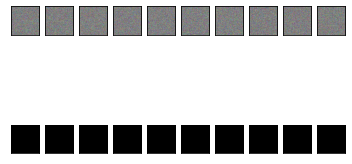

In [ ]:
scale = 1.0
n = 10
random_latent_vectors  = np.random.random((10, 224, 224, 3))
decoded_imgs  = vae.predict(random_latent_vectors)
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(random_latent_vectors[i].reshape(224, 224, 3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(224, 224, 3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Creación de modelos

### Parámetros

In [ ]:
IMG_SIZE = (224, 224, 3)

### Modelos anteriores

Modelo 5 (63%)

In [7]:
model = keras.models.load_model('sports_5.h5')
model.summary()

test_loss, test_acc = model.evaluate(Xtest)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_23 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_40 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_146 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_146 (MaxPooli  (None, 112, 112, 32)     0         
 ng2D)                                                           
                                                                 
 batch_normalization_141 (Ba  (None, 112, 112, 32)     128       
 tchNormalization)                                               
                                                                 
 dropout_134 (Dropout)       (None, 112, 112, 32)    

Modelo 6 (69%)

In [8]:
model = keras.models.load_model('sports_6.h5')
model.summary()

test_loss, test_acc = model.evaluate(Xtest)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                    

### Modelo final (71% ~)

In [ ]:
model = Sequential([
    data_augmentation,
    Rescaling(1.0 / 255.0),
    Conv2D(64, (3, 3), activation='relu', input_shape=IMG_SIZE, padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(100, activation='softmax'),
])


# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.05),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Train the model
model.fit(x=Xtrain, epochs=120, validation_data=Xvalid,
          shuffle=False, verbose=1)

# Evaluate the model
test_loss, test_acc = model.evaluate(Xtest)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
model.save('sports_8.h5')


In [6]:
model = keras.models.load_model('sports_7.h5')
model.summary()

test_loss, test_acc = model.evaluate(Xtest)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)


Model: "sequential_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_23 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 rescaling_40 (Rescaling)    (None, 224, 224, 3)       0         
                                                                 
 conv2d_146 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_146 (MaxPooli  (None, 112, 112, 32)     0         
 ng2D)                                                           
                                                                 
 batch_normalization_141 (Ba  (None, 112, 112, 32)     128       
 tchNormalization)                                               
                                                                 
 dropout_134 (Dropout)       (None, 112, 112, 32)    

### Predicciones del modelo 7

In [14]:
model = keras.models.load_model('sports_7.h5')
preds = model.predict(Xtest)
y_pred = np.argmax(preds, axis=1)
class_score = [0 for i in range(100)]
for i in range(100):
    for j in range(5):
        if y_pred[i*5+j] == i:
            class_score[i] += 1

labels = class_dictionary.values()
correct_by_class = pd.DataFrame({'labels': labels, 'correct': class_score})
save_path = 'correct_by_class_model7.csv'
correct_by_class.to_csv(save_path, index=False)

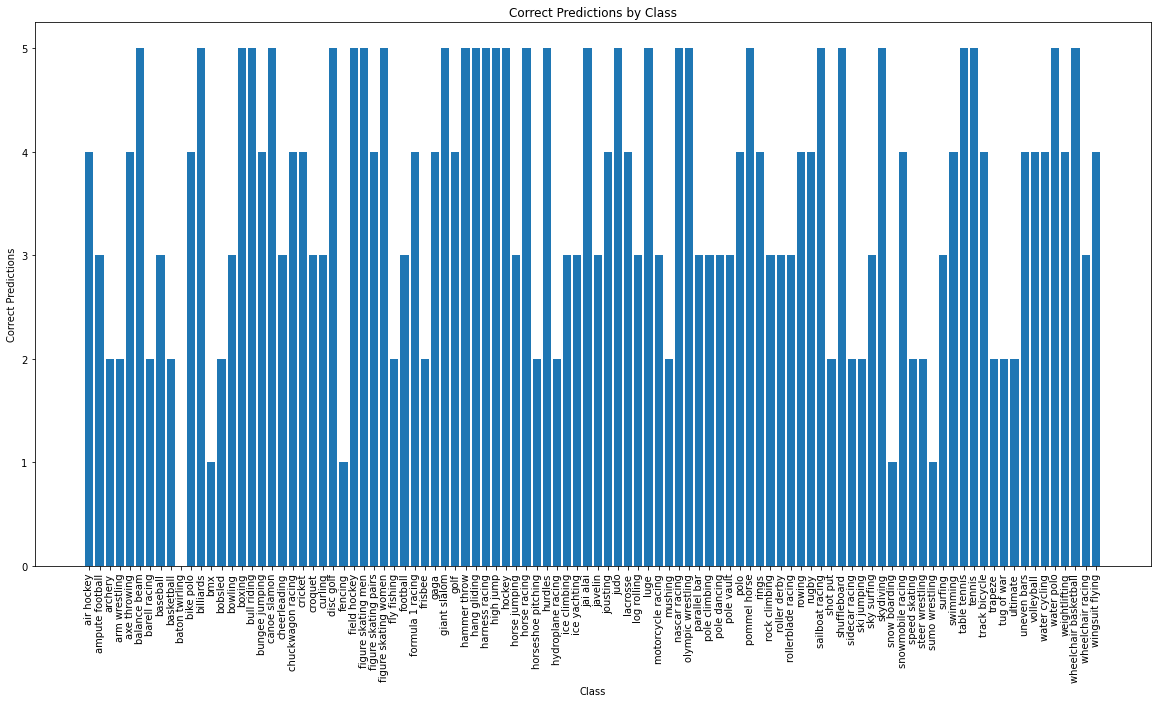

In [15]:
correct_by_class_model7 = pd.read_csv('correct_by_class_model7.csv')

# Histograma de predicciones correctas por clase
plt.figure(figsize=(20, 10))
plt.bar(correct_by_class_model7['labels'], correct_by_class_model7['correct'])
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Correct Predictions')
plt.title('Correct Predictions by Class')
plt.show()

## Wrapper

Se pudo haber incluido un Reshape en el modelo para que la entrada pudiese ser cualquier imagen, pero por ahora hay que transformarlas manualmente en código.

Numeros de clase: [ 8 87 31 36 15]
Real ['basketball', 'tennis', 'football', 'frisbee', 'boxing']
Predict: ['basketball', 'tennis', 'football', 'golf', 'boxing']


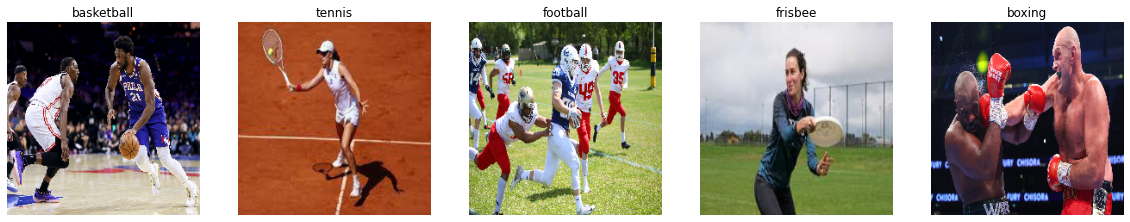

In [16]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
import tensorflow.keras as keras
csv_data = pd.read_csv('sports.csv')

grouped_by_id_label = csv_data.groupby(['class id', 'labels']).size().reset_index(name='counts') 

class_dictionary = dict(zip(grouped_by_id_label['class id'], grouped_by_id_label['labels']))

model = keras.models.load_model('sports_7.h5')
sports = ['basketball', 'tennis', 'football', 'frisbee', 'boxing']
basketball = plt.imread('wrapper_photos/basketball.jpg')
tennis = plt.imread('wrapper_photos/tennis.jpg')
images = []
for sport in sports:
    image = plt.imread('wrapper_photos/' + sport + '.jpg')
    image = cv2.resize(image, (224, 224))
    images.append(image)

# Plot de imagenes a probar
plt.figure(figsize=(20, 10))

for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
    plt.title(sports[i])

classification = model.predict(np.array(images))
classification = np.argmax(classification, axis=1)
print("Numeros de clase:", classification)
print("Real", sports)
print("Predict:", [class_dictionary[i] for i in classification])
